Run these command to download the dataset:
```sh
wget http://files.fast.ai/data/dogscats.zip
unzip dogscats.zip
```

In [1]:
!ls dogscats/

models	sample	test1  tmp  train  valid


In [2]:
import tqdm
import torch
import torch.optim as opt
import torch.nn as nn
from torch.utils import data as td
import torchvision as tv
import torchvision.transforms as tr
from torchvision.models import resnet34

In [18]:
import copy
import pandas as pd
%matplotlib inline

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
train_trans = tr.Compose([
    tr.RandomResizedCrop(224),
    tr.RandomHorizontalFlip(),
    tr.ToTensor(), 
    tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_iter = tv.datasets.ImageFolder('dogscats/train', transform=train_trans)
train_loader = td.DataLoader(train_iter, batch_size=16, shuffle=True, drop_last=True)

In [7]:
len(train_loader)

1437

In [8]:
valid_num_imgs = !find dogscats/valid/ -type f  | wc -l
valid_num_imgs = int(valid_num_imgs[0])
valid_num_imgs

2000

In [9]:
valid_trans = tr.Compose([
    tr.CenterCrop(224), 
    tr.ToTensor(), 
    tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
valid_iter = tv.datasets.ImageFolder('dogscats/valid', transform=valid_trans)
valid_loader = td.DataLoader(valid_iter, batch_size=16, shuffle=False, drop_last=True)

In [11]:
net = resnet34(pretrained=True)
layers = list(net.children())
last_layer = layers[-1]
last_layer.in_features, last_layer.out_features

(512, 1000)

In [12]:
for p in net.parameters():
    p.requires_grad = False

In [13]:
ult = nn.Sequential(
    nn.BatchNorm1d(num_features=last_layer.in_features),
    nn.Dropout(p=.5),
    nn.Linear(in_features=last_layer.in_features, out_features=2)
)
# net.fc = ult
net.fc = nn.Linear(in_features=last_layer.in_features, out_features=2)

In [14]:
net = net.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()

LR finder

In [27]:
dum_net = copy.deepcopy(net)
dum_opt = opt.SGD(dum_net.fc.parameters(), lr=1e-5)
sched = opt.lr_scheduler.StepLR(dum_opt, 60, 2)
lrs = []
losses = []
for data in tqdm.tqdm_notebook(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        dum_opt.zero_grad()
        outputs = dum_net(inputs)
        loss = criterion(outputs, labels)
        loss_f = loss.item()
        lr_f = sched.get_lr()[0]
        lrs.append(lr_f)
        losses.append(loss_f)
        if lr_f > 1:
            break
        loss.backward()
        dum_opt.step()
        sched.step()

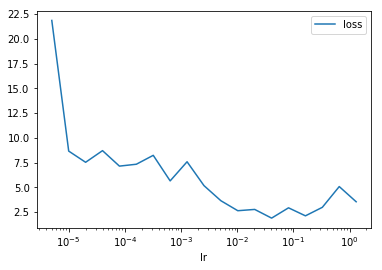

In [28]:
loss_full = pd.DataFrame({'lr': lrs, 'loss': losses})
loss_df = loss_full.groupby('lr').mean()
loss_df.plot(logx=True)

In [30]:
def accuracy():
    net.eval()
    total = 0
    correct= 0
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicts = torch.max(outputs, 1)
            total += labels.size()[0]
            correct += (predicts == labels).sum().cpu().item()
    return correct/total

In [31]:
optimizer = opt.SGD(net.fc.parameters(), lr=0.05)

In [32]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()
    for data in tqdm.tqdm_notebook(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(running_loss, accuracy())

2922.3031959868968 0.9785


2017.936619533226 0.9785


Left to do:
1. ~~LR finder~~
1. Why accuracy is slow? Cache validation set and move to device
1. Print loss and accuracy in tdqm
1. Better transformations, take from fast.ai
1. Different optimizers and hyper-parameters